---
**Autores**: Prof. João Nogueira e Prof. Dino Magri

**Contato**: `joaonogueira@fisica.ufc.br` e `professor.dinomagri@gmail.com`

**Licença deste notebook**: 
<br>
<img align="left" width="80" src="https://licensebuttons.net/l/by/3.0/88x31.png" />

<br>
<br>

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)


---

## Projeto - Parte 2 - Aprendizagem Supervisionada - Classificação - Exercícios

---
#### NOTA MÁXIMA: 25 pontos

#### NOME COMPLETO: `...`
--- 
<img align="center" width="150" src="https://logodownload.org/wp-content/uploads/2017/05/ifood-logo-0.png">



## Definição do Problema

O departamento de CRM/Marketing do iFood fez uma solicitação para o time de Ciência de Dados (que estão atrelados ao time de dados dentro da área de TI) para criar um modelo de Machine Learning para prever os clientes que darão Churn.


O objetivo deles com o modelo é atuar sobre os clientes com maiores chances de darem churn no próximo mês.

- A ação será realizada 1 vez por mês, todo dia 01.
- Como a frequência de compras dos clientes do IFood é relativamente alta, então ficou-se decidido na reunião com a área cliente que o modelo seria construído usando features construídas em um período fechado de 1 mês para prever se um dado cliente irá deixar de comprar (churn) no próximo mês. 

A métrica principal de avaliação do modelo é a AUC, dado que o score gerado pelo modelo será usado para ordenar a base.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import datetime

## Lendos os Dados

In [ ]:
df_orders = pd.read_csv("/content/drive/MyDrive/MBA - Big Data /Inteligência Artificial/Supervisionado/Classificação/Ifood/df_orders.csv")
df_orders.head(2)

,order_id,order_number,order_timestamp_local,order_shift,last_status_date_local,order_total,credit,paid_amount,delivery_type,scheduled,...,distance_merchant_customer,promo_is_promotion,normal_items_quantity,promo_items_quantity,order_lag_at_login,order_lead_at_login,order_date_local,valid_order,session_id,customer_id
0,630e2af0-b456-4b3a-b964-4d66ce5cc5df,1290139943,2019-12-11T13:22:06.497Z,weekday lunch,2019-12-11T15:22:39.156Z,28.90,14.0,24.9,DELIVERY,False,...,2722.603906,0.0,2.0,0.0,2.0,1.0,2019-12-11T00:00:00.000Z,1,ccbcf9e2-3728-4458-a813-4031ae22e4bd,48b6d81407646ca61163f064a426ce38ac08bed2ce84f0...
1,66f8163d-f081-4fbd-adb8-cfbbff9213f7,1141271215,2019-11-06T17:57:17.967Z,weekday dinner,2019-11-06T18:18:48.680Z,56.35,7.9,50.4,DELIVERY,False,...,1108.823183,1.0,0.0,1.0,7.0,1.0,2019-11-06T00:00:00.000Z,1,d9e94d88-ca88-4997-ad4c-62b9c0a35c1b,b3f74186880f5f9a79e0865ad8beab47e22b785b8b3bc0...


## Análise Exploratória (1 ponto)

**<span style="color:blue">(0.25 ponto)</span> `Q1`** Quantas linhas e colunas existem na base `df_orders`?

In [ ]:
print('Quantidade de linhas: {}, quantidade de colunas: {}'.format(df_orders.shape[0], df_orders.shape[1]))

Quantidade de linhas: 492138, quantidade de colunas: 43


**<span style="color:blue">(0.25 ponto)</span> `Q2`** Verifique se todos os pedidos são unicos.

In [ ]:
print('Quantidade de pedidos: {}\nQuantidade de pedidos unicos: {}\nDiferença: {}'.format(df_orders.shape[0], df_orders['order_number'].nunique(), (df_orders.shape[0] - df_orders['order_number'].nunique())))

Quantidade de pedidos: 492138
Quantidade de pedidos unicos: 492138
Diferença: 0


**<span style="color:blue">(0.25 ponto)</span> `Q3`** Qual o pedido mais antigo e o mais recente da base? Utilize a variável `order_timestamp_local`.

In [ ]:
df_orders.agg({'order_timestamp_local': ['min', 'max']})

,order_timestamp_local
min,2019-06-01T00:00:15.369Z
max,2019-12-31T23:31:59.972Z


**<span style="color:blue">(0.25 ponto)</span> `Q4`** Quantos usuários únicos existem na base?

In [ ]:
print('Existem {} usuários únicos na base'.format(df_orders['customer_id'].nunique()))

Existem 30079 usuários únicos na base


## Criação da ABT (10 pontos)

Será que variáveis como Recência, Frequência e Valor podem nos ajudar a prever se um dado cliente irá realizar um novo pedido no próximo mês?

Vamos criar variáveis que descrevem o comportamento do cliente com base em 1 mês e usar essas variáveis para prever se o cliente irá comprar no próximo mês (caso em que acontecerá um churn e talvez seja interessante oferecermos um cupom de desconto através de notificações no app).

**<span style="color:blue">(1.0 ponto)</span> `Q5`** Crie um DataFrame chamado `df_features_train` que deverá conter os dados do período 2019-06-01 (inclusivo) até 2019-07-01 (exclusivo), ou seja deve conter somente os dados referente ao mês 6.

In [ ]:
df_features_train = df_orders.query('order_timestamp_local >= "2019-06-01" & order_timestamp_local < "2019-07-01"')
df_features_train.head(2)

,order_id,order_number,order_timestamp_local,order_shift,last_status_date_local,order_total,credit,paid_amount,delivery_type,scheduled,...,distance_merchant_customer,promo_is_promotion,normal_items_quantity,promo_items_quantity,order_lag_at_login,order_lead_at_login,order_date_local,valid_order,session_id,customer_id
2,e8c55557-81d4-4159-bd2b-c144e5fbabe3,694742752,2019-06-11T20:42:32.058Z,weekday dinner,2019-06-11T22:42:54.005Z,53.8,4.0,49.8,DELIVERY,False,...,1642.258522,0.0,2.0,0.0,5.0,1.0,2019-06-11T00:00:00.000Z,1,035b33cd-6ddf-4ee2-a887-7ba490bb9700,c4f8999d4cb83cac8134b2051ffc611d5d660c049c3744...
3,34a60e0d-0042-49af-9aa8-4dc526a998c2,679245732,2019-06-05T19:16:42.111Z,weekday dinner,2019-06-05T21:17:13.264Z,58.9,4.0,54.9,DELIVERY,False,...,441.677507,0.0,1.0,0.0,9.0,2.0,2019-06-05T00:00:00.000Z,1,93f66506-a8ba-4c22-97ea-7489131958bb,ac89a3eb35853705a09d54f1e5988ad876628b986045cd...


**<span style="color:blue">(1.0 ponto)</span> `Q6`** Crie um DataFrame chamado `df_target_train` que deverá conter os dados do período 2019-07-01 (inclusivo) até 2019-08-01 (exclusivo), ou seja deve conter somente os dados referente ao mês 7.

Depois selecione apenas a coluna `customer_id` e remova os duplicados.

In [ ]:
df_target_train = df_orders.query('order_timestamp_local >= "2019-07-01" & order_timestamp_local < "2019-08-01"')['customer_id'].drop_duplicates()
df_target_train.head(3)

**<span style="color:blue">(2.0 ponto)</span> `Q7`** Faça o agrupamento no DataFrame `df_features_train` pela feature `customer_id`. Faça as agregações abaixo, renomeando o resultado para as seguintes colunas `receita_1m`, `qtd_pedidos_1m` e `data_ultima_venda`, respectivamente.

- 'paid_amount' - 'sum'
- 'order_id' - 'nunique'
- 'order_timestamp_local' - 'max'

Lembre-se de utilizar o conceito que vimos em sala para renomear o resultado da agregação.

Também utilize o método `reset_index` para reinicar os indices.

Salve na variável `df_abt_train`.

In [ ]:
df_abt_train = (
    df_features_train
    .groupby('customer_id')
    .agg(receita_1m = ('paid_amount', 'sum'),
         qtd_pedidos_1m = ('order_id', 'nunique'),
         data_ultima_venda = ('order_timestamp_local', 'max')
    )
    .reset_index()
)

df_abt_train.head(2)

,customer_id,receita_1m,qtd_pedidos_1m,data_ultima_venda
0,0001a8e61d8b08ad436e8e6f4adeb399b88df962c72d9d...,102.0,2,2019-06-15T21:57:51.803Z
1,0001a9f97d01d2696cf70c7657ee2d039388d691720ff9...,52.0,1,2019-06-11T12:10:33.822Z


**<span style="color:blue">(3.0 pontos)</span> `Q8`** Utilize o método `.assign` do DataFrame para fazer as seguintes alterações:

- Altere o tipo da coluna `data_ultima_venda` para o formato de data utilizando o comando `pd.to_datetime` com o parâmetro `utc=True`.
- Crie uma nova coluna chamada `data_ref` com o valor de `2019-07-01` e faça a converção utilizando o comando `pd.to_datetime` com o parâmetro `utc=True`
- Crie uma nova coluna chamada `recencia` e salve os dias referentes a subtração da coluna `data_ref` e `data_ultima_venda`. Lembre-se de extrair os dias (`.dt.days`)
- Por fim, selecione apenas as seguintes colunas: `['data_ref', 'customer_id', 'receita_1m', 'qtd_pedidos_1m', 'recencia']`

O resultado dessas alterações devem ser salvas na variável `df_abt_train`


In [ ]:
df_abt_train = (
    df_abt_train
    .assign(data_ultima_venda = lambda df: pd.to_datetime(df['data_ultima_venda'], utc= True))
    .assign(data_ref = pd.to_datetime('2019-07-01', utc= True))
    .assign(recencia = lambda df: (df['data_ref'] - df['data_ultima_venda']).dt.days)
    .filter(['data_ref', 'customer_id', 'receita_1m', 'qtd_pedidos_1m', 'recencia'])
)

df_abt_train.head(2)

,data_ref,customer_id,receita_1m,qtd_pedidos_1m,recencia
0,2019-07-01 00:00:00+00:00,0001a8e61d8b08ad436e8e6f4adeb399b88df962c72d9d...,102.0,2,15
1,2019-07-01 00:00:00+00:00,0001a9f97d01d2696cf70c7657ee2d039388d691720ff9...,52.0,1,19


**<span style="color:blue">(1.0 pontos)</span> `Q9`** Faça o `merge` com o DataFrame `df_abt_train` com o `df_target_train` com os seguintes parametros:

- `how='left'`
- `on='customer_id'`
- `indicator=True`

Salve o merge na variável `df_abt_train`.


In [ ]:
df_abt_train = df_abt_train.merge(df_target_train, how= 'left', on= 'customer_id', indicator= True)

In [ ]:
df_abt_train.head(2)

,data_ref,customer_id,receita_1m,qtd_pedidos_1m,recencia,_merge
0,2019-07-01 00:00:00+00:00,0001a8e61d8b08ad436e8e6f4adeb399b88df962c72d9d...,102.0,2,15,left_only
1,2019-07-01 00:00:00+00:00,0001a9f97d01d2696cf70c7657ee2d039388d691720ff9...,52.0,1,19,left_only


**<span style="color:blue">(1.0 pontos)</span> `Q10`** Utilize o método `.assign` para criar a coluna `churn_next_month`.

Utilize a função `np.where` para fazer a criação. Compare as colunas `_merge` com `left_only`, se ambas forem iguais, o resultado deve ser 1, caso contrário deve ser 0.

* Obs: não esquecer de dropar a coluna `_merge` depois de ter criado a variável target.

In [ ]:
df_abt_train = df_abt_train.assign(churn_next_month = lambda df: np.where(df['_merge'] == 'left_only', 1, 0)).drop(['_merge'], axis= 1)
df_abt_train.head()

,data_ref,customer_id,receita_1m,qtd_pedidos_1m,recencia,churn_next_month
0,2019-07-01 00:00:00+00:00,0001a8e61d8b08ad436e8e6f4adeb399b88df962c72d9d...,102.0,2,15,1
1,2019-07-01 00:00:00+00:00,0001a9f97d01d2696cf70c7657ee2d039388d691720ff9...,52.0,1,19,1
2,2019-07-01 00:00:00+00:00,0004720dc16aed1f98fd79f59736170e0d686199cd9ae5...,59.3,1,29,1
3,2019-07-01 00:00:00+00:00,0006a32816a3af172048de7db87c97c4c8c7ad7e6385fa...,95.2,2,1,1
4,2019-07-01 00:00:00+00:00,00081913eb21cd12aecc831bda704f8c6482723b55e664...,27.0,1,13,1


**<span style="color:blue">(1.0 pontos)</span> `Q11`** Verifique a distribuição da coluna `churn`.

In [ ]:
df_abt_train['churn_next_month'].value_counts(1)

0    0.613086
1    0.386914
Name: churn_next_month, dtype: float64

In [ ]:
df_abt_train.shape

(30079, 6)

<img align="left" width="20" src="http://dinomagri.com/imgs/checkpoint.png" /> &nbsp; **CHECKPOINT** - O DataFrame `df_abt_train` deverá conter exatamente `(30079, 6)`. E a distribuição da variável target deve ser `0.613086` para não-churn (0) e `0.386914` para churn (1).

# Modelagem (14 pontos)

**<span style="color:blue">(2 pontos)</span> `Q12`** Crie uma ABT Out of Time avançando 1 mês no código anterior. Utilize o mês 08 para criar essa ABT. Utilize os nomes `df_features_oot`, `df_target_oot` e `df_abt_oot`.

In [ ]:
df_features_oot = df_orders.query('order_timestamp_local >= "2019-07-01" & order_timestamp_local < "2019-08-01"')
df_target_oot = df_orders.query('order_timestamp_local >= "2019-08-01" & order_timestamp_local < "2019-09-01"').filter(['customer_id']).drop_duplicates()

In [ ]:
df_abt_oot = (
    df_features_oot
    .groupby('customer_id')
    .agg(receita_1m = ('paid_amount', 'sum'),
         qtd_pedidos_1m = ('order_id', 'nunique'),
         data_ultima_venda = ('order_timestamp_local', 'max'))
    .reset_index()
    .assign(data_ultima_venda = lambda df: pd.to_datetime(df['data_ultima_venda'], utc= True))
    .assign(data_ref = pd.to_datetime('2019-08-01', utc= True))
    .assign(recencia = lambda df: (df['data_ref'] - df['data_ultima_venda']).dt.days)
    .merge(df_target_oot, how= 'left', on= 'customer_id', indicator= True)
    .assign(churn_next_month = lambda df: np.where(df['_merge'] == 'left_only', 1, 0))
    .filter(['data_ref', 'customer_id', 'receita_1m', 'qtd_pedidos_1m', 'recencia', 'churn_next_month'])
)

df_abt_oot.head(2)

,data_ref,customer_id,receita_1m,qtd_pedidos_1m,recencia,churn_next_month
0,2019-08-01 00:00:00+00:00,000a1fac4f7a67cc3f2e7667167597cb2c9a1b9edafe18...,85.89,3,11,0
1,2019-08-01 00:00:00+00:00,0014b7013c66a05d0b5ce0687d614ac220d3ae1af398d2...,211.96,5,11,0


In [ ]:
df_abt_oot.shape

(18441, 6)

In [ ]:
df_abt_oot['churn_next_month'].value_counts(1)

0    0.759558
1    0.240442
Name: churn_next_month, dtype: float64

**Porque devemos criar uma ABT Out of Time?**

ADICIONE SUA RESPOSTA AQUI

Devemos criar a OOT pois queremos avaliar ao longo do tempo o comportamento que os clientes da base tem. A OOT funciona como se fosse uma base de teste, porém ela é criada considerando o tempo e não de forma aleatória como é a técnica de hold-out por exemplo.

<img align="left" width="20" src="http://dinomagri.com/imgs/checkpoint.png" /> &nbsp; **CHECKPOINT** - O DataFrame `df_abt_oot` deverá conter exatamente `(18441, 6)`. E a distribuição da variável target deve ser `0.759558` para não-churn (0) e `0.240442` para churn (1).

**<span style="color:blue">(1 ponto)</span> `Q13`** Faça um estudo de valores faltantes tanto na `df_abt_train` e `df_abt_oot`. 

In [ ]:
df_abt_train.isna().sum()

data_ref            0
customer_id         0
receita_1m          0
qtd_pedidos_1m      0
recencia            0
churn_next_month    0
dtype: int64

In [ ]:
df_abt_oot.isna().sum()

data_ref            0
customer_id         0
receita_1m          0
qtd_pedidos_1m      0
recencia            0
churn_next_month    0
dtype: int64

ADICIONE SUA RESPOSTA AQUI: <font color='yellow'>Não tem valores faltantes</font>

**<span style="color:blue">(1 ponto)</span> `Q14`**  Treine uma árvore de decisão na base de treino usando Stratified K-Fold e avalie utilizando a métrica **AUC** na base Out of Time.

Utilize o parametro `random_state=42`.

Lembre-se se instalar as bibliotecas necessárias (scikit-learn, feature-engine, etc).

Utilize o método cross-val-score para avaliar os resultados da validação cruzada no conjunto de treino.

Os seguintes passos devem estar contemplados:

- Importar as bibliotecas necessárias
- Criar as variáveis target, key_vars, num_vars, cat_vars, features
- Criar X_train e y_train
- Criar o pipeline (mesmo que utilize apenas 1 step)
- Utilizar StratifiedKFold e salve na variável skf
- Utilizar o cross_val_score
- Calcular a média da AUC para todos os folds calculados no passo anterior
- Criar X_oot e y_oot
- "Fit" o pipeline criado
- Calcular e predizer a probabilidade da classe 1 (y_proba) na OOT
- Calcular a AUC score na OOT

**ATENÇÃO: Parte dessas etapas se repetem para os próximos exercícios**

In [ ]:
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 7.8 MB/s 


In [ ]:
from sklearn.tree               import DecisionTreeClassifier
from sklearn.pipeline           import Pipeline
from feature_engine.imputation  import ArbitraryNumberImputer
from sklearn.model_selection    import StratifiedKFold
from sklearn.model_selection    import cross_val_score

# Variavel Target
target = 'churn_next_month'

key_vars = ['data_ref', 'customer_id']
num_vars = ['receita_1m', 'qtd_pedidos_1m', 'recencia']
cat_vars = [] # Não temos variáveis categoricas
features = num_vars + cat_vars

# Spliting
X_train = df_abt_train.filter(features)
y_train = df_abt_train[target]

# Pipeline
dt = Pipeline(steps= [
    ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
    ('decision_tree', DecisionTreeClassifier(random_state= 42))
])

# Cross_Validation
skf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

cv_results = cross_val_score(estimator= dt, X= X_train, y= y_train, scoring= 'roc_auc', cv= skf, n_jobs= -1)
print(f'Decision Tree: AUC Treino/CV = {cv_results.mean()}')

Decision Tree: AUC Treino/CV = 0.6147471340887323


In [ ]:
# Base Out Of Time
## Spliting
X_oot = df_abt_oot.filter(features)
y_oot = df_abt_oot[target]

dt.fit(X_train, y_train)
y_proba = dt.predict_proba(X_oot)[:, 1]

from sklearn.metrics import roc_auc_score
print(f'Decision Tree: AUC Test/OOT = {roc_auc_score(y_oot, y_proba)}')

Decision Tree: AUC Test/OOT = 0.5942238945608709


**<span style="color:blue">(1 ponto)</span> `Q15`** Treine uma Random Forest na base de treino usando Stratified K-Fold e avalie utilizando a métrica **AUC** na base Out of Time.

Utilize o parametro `random_state=42`

**ATENÇÃO: Utilize as variáveis criadas anteriormente (X_train, y_train, X_oot, y_oot, skf)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps= [
    ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
    ('random_forest', RandomForestClassifier(random_state= 42))
])

cv_results = cross_val_score(estimator= rf, X= X_train, y= y_train, scoring= 'roc_auc', cv= skf, n_jobs= -1)
print(f'Decision Tree: AUC Treino/CV = {cv_results.mean()}')

Decision Tree: AUC Treino/CV = 0.677727188074699


In [ ]:
# Base Out of Time

rf.fit(X_train, y_train)
y_proba = rf.predict_proba(X_oot)[:, 1]

print(f'Random Forest: AUC Test/OOT = {roc_auc_score(y_oot, y_proba)}')

Random Forest: AUC Test/OOT = 0.663481166176368


**<span style="color:blue">(1 ponto)</span> `Q16`** Treine um LGBM na base de treino usando Stratified K-Fold e avalie utilizando a métrica **AUC** na base Out of Time.

Utilize o parametro `random_state=42`

**ATENÇÃO: Utilize as variáveis criadas anteriormente (X_train, y_train, X_oot, y_oot, skf)**

In [ ]:
from lightgbm import LGBMClassifier

lgbm = Pipeline(steps= [
    ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
    ('lgbm', LGBMClassifier(random_state= 42))
])

cv_results = cross_val_score(estimator= lgbm, X= X_train, y= y_train, scoring= 'roc_auc', cv= skf, n_jobs= -1)
print(f"LGBM: AUC Treino/CV = {cv_results.mean()}")

LGBM: AUC Treino/CV = 0.7519336629173853


In [ ]:
# Base Out of Time

lgbm.fit(X_train, y_train)
y_proba = lgbm.predict_proba(X_oot)[:, 1]

print(f'LGBM: AUC Test/OOT = {roc_auc_score(y_oot, y_proba)}')

LGBM: AUC Test/OOT = 0.7330607764614375


**<span style="color:blue">(1 ponto)</span> `Q17`** Para o melhor algoritmo dos 3 treinados anteriormente (lightgbm), faça um GridSearchCV para encontrar um conjunto de hiperparâmetros mais otimizado (lembre de otimizar a **AUC**).

Utilize os seguintes hiperparâmetros:

    'lgbm__max_depth': [3, 5, 7, 9],
    'lgbm__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'lgbm__n_estimators': [100, 300, 500]


**ATENÇÃO: Utilize as variáveis criadas anteriormente (X_train, y_train, X_oot, y_oot, skf)**

**ATENÇÃO: Utilize o pipeline já criado para o algoritmo LightGBM**

In [ ]:
# O melhor algoritmo foi o LGBM, logo iremos fazer um grid search para ele
from sklearn.model_selection import GridSearchCV

grid_parameters = {
    'lgbm__max_depth': [3, 5, 7, 9],
    'lgbm__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'lgbm__n_estimators': [100, 300, 500]
}

grid_search = GridSearchCV(estimator= lgbm, param_grid= grid_parameters, scoring= 'roc_auc', cv= skf, n_jobs= -1, verbose= 1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('numeric_imputer',
                                        ArbitraryNumberImputer(arbitrary_number=-999,
                                                               variables=['receita_1m',
                                                                          'qtd_pedidos_1m',
                                                                          'recencia'])),
                                       ('lgbm',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbm__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
                         'lgbm__max_depth': [3, 5, 7, 9],
                         'lgbm__n_estimators': [100, 300, 500]},
             scoring='roc_auc', verbose=1)

In [ ]:
# Recupere o melhor AUC
grid_search.best_score_

0.7569120124999488

In [ ]:
# Recupere os hiperparâmetros
grid_search.best_params_

{'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 100}

In [ ]:
# Avalei o desempenho do melhor modelo no grid search na base OOT
# Crie a variável best_model e salve o melhor estimador do grid_search nessa variável
best_model = grid_search.best_estimator_

# Treine o melhor estimador (best_model)
best_model.fit(X_train, y_train)

# Calcule a probabilidade da classe 1 para a base OOT
y_proba = best_model.predict_proba(X_oot)[:,1]

# Imprima a AUC
print(f"Best LGBM: AUC Test/OOT = {roc_auc_score(y_oot, y_proba)}")

Best LGBM: AUC Test/OOT = 0.7372138323518183


Melhoramos a nossa performance com um grid search bem simples! Muito bom! 

Talvez ainda haja espaço para melhorias no desempenho do modelo. Lembrando que temos apenas 3 variáveis: `receita_1m`, `qtd_pedidos_1m` e `recencia`. 

Vamos utilizar a variável `order_shift` para criar mais 10 features para verificar se isso irá ajudar o modelo de Machine Learning a predizer qual cliente irá dar **churn**.

**<span style="color:blue">(1 ponto)</span> `Q18`** Utilize o método `pd.crosstab` com o parâmetro `normalize='index'` nas colunas `customer_id` e `order_shift`. Lembre-se de resetar o indíce.

Salve o resultado no DataFrame `df_customer_order_shift_train`.

Imprima os 5 primeiros elementos desse DataFrame.

In [ ]:
df_customer_order_shift_train = pd.crosstab(df_features_train['customer_id'], df_features_train['order_shift'], normalize= 'index').reset_index()
df_customer_order_shift_train.head()

order_shift,customer_id,weekday breakfast,weekday dawn,weekday dinner,weekday lunch,weekday snack,weekend breakfast,weekend dawn,weekend dinner,weekend lunch,weekend snack
0,0001a8e61d8b08ad436e8e6f4adeb399b88df962c72d9d...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0
1,0001a9f97d01d2696cf70c7657ee2d039388d691720ff9...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004720dc16aed1f98fd79f59736170e0d686199cd9ae5...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0006a32816a3af172048de7db87c97c4c8c7ad7e6385fa...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0
4,00081913eb21cd12aecc831bda704f8c6482723b55e664...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**<span style="color:blue">(1 ponto)</span> `Q19`** Faça o merge com a `df_abt_train` com os seguintes parâmetros:

- `how='left'`
- `on='customer_id'`

Salve o DataFrame resultante na mesma variável `df_abt_train`.

Imprima as 5 primeiras linhas.

In [ ]:
df_abt_train = df_abt_train.merge(df_customer_order_shift_train, how= 'left',on= 'customer_id')
df_abt_train.head()

,data_ref,customer_id,receita_1m,qtd_pedidos_1m,recencia,churn_next_month,weekday breakfast,weekday dawn,weekday dinner,weekday lunch,weekday snack,weekend breakfast,weekend dawn,weekend dinner,weekend lunch,weekend snack
0,2019-07-01 00:00:00+00:00,0001a8e61d8b08ad436e8e6f4adeb399b88df962c72d9d...,102.0,2,15,1,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0
1,2019-07-01 00:00:00+00:00,0001a9f97d01d2696cf70c7657ee2d039388d691720ff9...,52.0,1,19,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-07-01 00:00:00+00:00,0004720dc16aed1f98fd79f59736170e0d686199cd9ae5...,59.3,1,29,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2019-07-01 00:00:00+00:00,0006a32816a3af172048de7db87c97c4c8c7ad7e6385fa...,95.2,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0
4,2019-07-01 00:00:00+00:00,00081913eb21cd12aecc831bda704f8c6482723b55e664...,27.0,1,13,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**<span style="color:blue">(1 ponto)</span> `Q20`** Replique essas duas etapas para a base de OOT.

- Crie o DataFrame `df_customer_order_shift_oot` utilizando o comando `pd.crosstab` com o parâmetro `normalize='index'`. Lembre-se de resetar o indice.

- Faça o merge com a `df_abt_oot` com os parâmetros `how='left'` e `on='customer_id'`.

- Imprime as 5 primeiras linhas do `df_abt_oot`.


In [ ]:
df_customer_order_shift_oot = pd.crosstab(df_features_oot['customer_id'], df_features_oot['order_shift'], normalize= 'index').reset_index()
df_customer_order_shift_oot.head()

order_shift,customer_id,weekday breakfast,weekday dawn,weekday dinner,weekday lunch,weekday snack,weekend breakfast,weekend dawn,weekend dinner,weekend lunch,weekend snack
0,000a1fac4f7a67cc3f2e7667167597cb2c9a1b9edafe18...,0.0,0.0,0.666667,0.0,0.000,0.0,0.0,0.333333,0.0,0.000
1,0014b7013c66a05d0b5ce0687d614ac220d3ae1af398d2...,0.0,0.0,0.400000,0.0,0.000,0.0,0.0,0.600000,0.0,0.000
2,00150a9d8edc32b5ac2c1a8089e5615dbd297cea2c6cba...,0.0,0.0,0.000000,0.5,0.000,0.0,0.0,0.500000,0.0,0.000
3,00197c67cab97917c3e147877fc36ae9e9208f4bd578ca...,0.0,0.0,0.800000,0.0,0.000,0.0,0.0,0.000000,0.0,0.200
4,001b8d424e1aa9b762831ccce74a6b4c648a83f2d8a239...,0.0,0.0,0.250000,0.5,0.125,0.0,0.0,0.000000,0.0,0.125


In [ ]:
df_abt_oot = df_abt_oot.merge(df_customer_order_shift_oot, how= 'left', on= 'customer_id')
df_abt_oot.head()

,data_ref,customer_id,receita_1m,qtd_pedidos_1m,recencia,churn_next_month,weekday breakfast,weekday dawn,weekday dinner,weekday lunch,weekday snack,weekend breakfast,weekend dawn,weekend dinner,weekend lunch,weekend snack
0,2019-08-01 00:00:00+00:00,000a1fac4f7a67cc3f2e7667167597cb2c9a1b9edafe18...,85.89,3,11,0,0.0,0.0,0.666667,0.0,0.000,0.0,0.0,0.333333,0.0,0.000
1,2019-08-01 00:00:00+00:00,0014b7013c66a05d0b5ce0687d614ac220d3ae1af398d2...,211.96,5,11,0,0.0,0.0,0.400000,0.0,0.000,0.0,0.0,0.600000,0.0,0.000
2,2019-08-01 00:00:00+00:00,00150a9d8edc32b5ac2c1a8089e5615dbd297cea2c6cba...,164.60,2,14,0,0.0,0.0,0.000000,0.5,0.000,0.0,0.0,0.500000,0.0,0.000
3,2019-08-01 00:00:00+00:00,00197c67cab97917c3e147877fc36ae9e9208f4bd578ca...,196.20,5,2,0,0.0,0.0,0.800000,0.0,0.000,0.0,0.0,0.000000,0.0,0.200
4,2019-08-01 00:00:00+00:00,001b8d424e1aa9b762831ccce74a6b4c648a83f2d8a239...,238.68,8,0,0,0.0,0.0,0.250000,0.5,0.125,0.0,0.0,0.000000,0.0,0.125


Criamos mais 10 variáveis tanto na ABT de treino quanto na de teste (OOT). Essas variáveis indicam o percentual de pedidos realizados por cada usuário em um horário específico do dia.

- weekday breakfast
- weekday dawn
- weekday dinner
- weekday lunch
- weekday snack
- weekend breakfast
- weekend dawn
- weekend dinner
- weekend lunch
- weekend snack

In [ ]:
# Verifique as dimensões de df_abt_train e df_abt_oot
print(f'Dimensão Train: {df_abt_train.shape}')
print(f'Dimensão OOT: {df_abt_oot.shape}')

Dimensão Train: (30079, 16)
Dimensão OOT: (18441, 16)


<img align="left" width="20" src="http://dinomagri.com/imgs/checkpoint.png" /> &nbsp; **CHECKPOINT** - O DataFrame `df_abt_train` deverá conter exatamente `(30079, 16)` e DataFrame `df_abt_oot` deverá conter `(18441, 16)`.

**<span style="color:blue">(1 ponto)</span> `Q21`** Com as features criadas, vamos utilizar o melhor algoritmo testado até o momento (LighGBM) para avaliar se as novas features impactam o modelo a ser gerado. Avalie utilizando a métrica **AUC**.

- Necessário recriar o X_train, y_train, X_oot e y_oot incluindo as novas features.
- Recuperar os hiperpâmetros do melhor modelo (best_model) para serem utilizados
- Crie um novo pipeline adicionando os hiperparâmetro recuperados.
- "Fit" o pipeline criado
- Calcular e predizer a probabilidade da classe 1 (y_proba) na OOT
- Calcular a AUC score na OOT

In [ ]:
# Utilize as seguintes variáveis:
target = 'churn_next_month'
num_vars = ['receita_1m', 'qtd_pedidos_1m', 'recencia', 
            'weekday breakfast', 'weekday dawn', 'weekday dinner', 'weekday lunch', 'weekday snack',
            'weekend breakfast', 'weekend dawn', 'weekend dinner', 'weekend lunch', 'weekend snack']
cat_vars = []
features = num_vars + cat_vars

# Adicione seu código aqui
X_train = df_abt_train.filter(features)
y_train = df_abt_train[target]

X_oot = df_abt_oot.filter(features)
y_oot = df_abt_oot[target]

In [ ]:
best_params = best_model[-1].get_params()
model_pipe = Pipeline(steps=[
    ('numeric_imputer', ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
    ('lgbm', LGBMClassifier(**best_params))
])

In [ ]:
model_pipe.fit(X_train, y_train)
y_proba = model_pipe.predict_proba(X_oot)[:, 1]
print(f"Best LGBM with 13 features: AUC Test/OOT = {roc_auc_score(y_oot, y_proba)}")

Best LGBM with 13 features: AUC Test/OOT = 0.7362892591979673


**<span style="color:blue">(1 ponto)</span> `Q22`** Houve melhora em relação ao modelo anterior?

**[RESPOSTA]**: 

**<span style="color:blue">(1 ponto)</span> `Q23`** Qual foi o melhor modelo encontrado e quais as features utilizadas?

**[RESPOSTA]**: Esse modelo com mais variáveis não melhorou a performance em relação ao nosso modelo anterior obtido no grid search. 

Obtivemos aqui uma performance de `0.736`, enquanto antes tínhamos `0.737`. Logo, ao que parece ao adicionarmos mais variáveis não conseguimos melhorar a performence do modelo.

**<span style="color:blue">(1 ponto)</span> `Q24`** Rode o shap values para entender quais as variáveis mais importantes do modelo e como elas se relacionam com a variável target (código já está disponível, basta apenas executar e interpretar para responder as perguntas abaixo).

**Responda:**

- **Qual a variável mais importante?**
- **Como ela se relaciona com a variável target?**
- **Como as outras variáveis se relacionam com a variável target?**

In [ ]:
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 356 kB 7.9 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491700 sha256=72e8fe704b4e7c01f674322676d27f4dd5d062cb28cf39cdf69b03964240d71f
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
features = ['receita_1m', 'qtd_pedidos_1m', 'recencia']

X_train = df_abt_train[features]
X_oot   = df_abt_oot[features]

In [ ]:
best_model

Pipeline(steps=[('numeric_imputer',
                 ArbitraryNumberImputer(arbitrary_number=-999,
                                        variables=['receita_1m',
                                                   'qtd_pedidos_1m',
                                                   'recencia'])),
                ('lgbm',
                 LGBMClassifier(learning_rate=0.05, max_depth=3,
                                random_state=42))])

In [ ]:
import shap
explainer = shap.TreeExplainer(best_model[-1])

In [ ]:
X_oot_transformado = best_model[:-1].transform(X_oot)

In [ ]:
shap_values = explainer.shap_values(X_oot_transformado)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


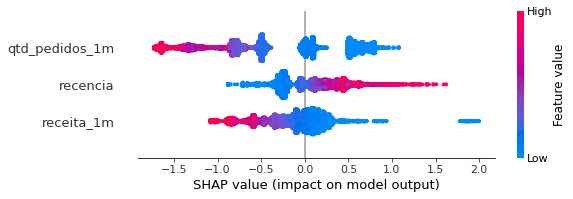

In [ ]:
shap.summary_plot(shap_values[1], X_oot_transformado, plot_type='dot')

**ADICIONE SUAS RESPOSTAS AQUI**

- **Qual a variável mais importante?** A variável `qtd_pedidos_1m` é a mais importante, embora as outras estejam ali bem próximas em termos de importância.


- **Como ela se relaciona com a variável target?** Quantos mais pedidos foram realizados no mês anterior, maior é a chance de se não comprar no mês seguinte. Bastante interessante, né? Isso provavelmente acontece porque se um cliente gasta muito no mês anterior, ele tende a não gastar no mês seguinte devido a orçamento financeiro. Será que faz sentido aumentar o tempo de criação tanto do target quanto das features?


- **Como as outras variáveis se relacionam com a variável target?**
 * `recencia`: quanto menor a recência, maior é a chance de comprar no próximo mês (outro indicativo de que talvez precisemos aumentar os meses da safra para criação das features e do target).
 * `receita_1m`: quanto maior a receita (gasto do cliente), maior é a chance de comprar no próximo mês.